# Text data with pytorch

##### 2.1 Word embedding:
## 2.1.1. Reading `txt` files, tokenizing texts and building a vocabulary
## 2.1.2. Define Vocabulary
## 2.1.3. Continous bag of words using embedding layer
- 2.1.4. Train models and evaluate performance
- 2.1.5. Compute cosine similarity matrix of the vocabulary based on the trained embedding
- 2.1.6. Visualize the embedding space

##### 2.2 Conjugating be and have:
- 2.2.1 Attention Layer
- 2.2.2. Train models and evaluate performance

##### 2.3 Text generation:
- 2.3.1. Next Word
- 2.3.2. Train models and evaluate performance
- 2.3.3. Beam Search
- 2.3.3. Sentence creation


_______________________________________________

# 2.1 Word embedding

In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

import numpy as np

import os
import re
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from utils import train, set_device, compute_accuracy

torch.manual_seed(265)
torch.set_default_dtype(torch.double)

device = torch.device("cpu")
print(f"Device {device}.")


## 2.1.1. Reading `txt` files, tokenizing texts and building a vocabulary

In [ ]:
# tokenizer will split a long text into a list of english words
TOKENIZER_EN = get_tokenizer('basic_english')
# Where we will store / load all our models, datasets, vocabulary, etc.
PATH_GENERATED = './generated/'
# Minimum number of occurence of a word in the text to add it to the vocabulary
MIN_FREQ = 100

# If you want to remove some characters to get rid of noise
# specials=["<unk>", ",", ".", "!", "?"] 
specials = []

# List of posible words to use
target_words = ["be", "am", "are", "is", "was", "were", "been", "being", "have", "has", "had", "having"]
taget_words_size = len(target_words) 


def read_files(datapath='./data_train/'):
    """
    Return a list of strings, one for each line in each .txt files in 'datapath'
    """
    # Find all txt files in directory 
    files = os.listdir(datapath)
    files = [datapath + f for f in files if f.endswith(".txt")]
    
    # Stores each line of each book in a list
    lines = []
    for f_name in files:
        with open(f_name) as f:
            lines += f.readlines()
    return lines

def tokenize(lines, tokenizer=TOKENIZER_EN):
    """
    Tokenize the list of lines
    """
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text

def yield_tokens(lines, tokenizer=TOKENIZER_EN):
    """
    Yield tokens, ignoring names and digits to build vocabulary
    """
    # Match any word containing digit
    no_digits = '\w*[09]+\w*'
    # Match word containing a uppercase 
    no_names = '\w*[A-Z]+\w*'
    # Match any sequence containing more than one space
    no_spaces = '\s+'
    
    for line in lines:
        # Remove special characters
        line = ''.join([char for char in line if char not in specials])
        line = re.sub(no_digits, ' ', line)
        line = re.sub(no_names, ' ', line)
        line = re.sub(no_spaces, ' ', line)
        yield tokenizer(line)

def count_freqs(words, vocab):
    """
    Count occurrences of each word in vocabulary in the data
    
    Useful to get some insight on the data and to compute loss weights
    """

    vocab_stoi = vocab.get_stoi()

    freqs = torch.zeros(len(vocab), dtype=torch.int)
    for w in words:
        if w in vocab_stoi:
            freqs[vocab[w]] += 1
    return freqs

def create_vocabulary(lines, min_freq=MIN_FREQ):
    """
    Create a vocabulary (list of known tokens) from a list of strings
    """
    # vocab contains the vocabulary found in the data, associating an index to each word
    vocab = build_vocab_from_iterator(yield_tokens(lines), min_freq=min_freq, specials=["<unk>"])
    # Since we removed all words with an uppercase when building the vocabulary, we skipped the word "I"
    vocab.append_token("i")
    # Value of default index. This index will be returned when OOV (Out Of Vocabulary) token is queried.
    vocab.set_default_index(vocab["<unk>"])
    # SANITAZE THE INPUT, Get rid of the unkown words 

    return vocab

## 2.1.2. Define Vocabulary

In [ ]:
# ----------------------- Tokenize texts -------------------------------
# Load tokenized versions of texts if you have already generated it
# Otherwise, create it and save it
PATH_WORDS = "words/"
if os.path.isfile(PATH_GENERATED + PATH_WORDS +"words_train.pt"):
    words_train = torch.load(PATH_GENERATED + PATH_WORDS +"words_train.pt")
    words_val = torch.load(PATH_GENERATED + PATH_WORDS +"words_val.pt")
    words_test = torch.load(PATH_GENERATED + PATH_WORDS +"words_test.pt")
else:
    # Get lists of strings, one for each line in each .txt files in 'datapath' 
    lines_books_train = read_files('./data_train/')
    lines_books_val = read_files('./data_val/')
    lines_books_test = read_files('./data_test/')

    # List of words contained in the dataset
    words_train = tokenize(lines_books_train)
    words_val = tokenize(lines_books_val)
    words_test = tokenize(lines_books_test)
    
    torch.save(words_train , PATH_GENERATED + PATH_WORDS +"words_train.pt")
    torch.save(words_val , PATH_GENERATED + PATH_WORDS +"words_val.pt")
    torch.save(words_test , PATH_GENERATED + PATH_WORDS +"words_test.pt")


# ----------------------- Create vocabulary ----------------------------
VOCAB_FNAME = "vocabulary.pt"
# Load vocabulary if you have already generated it
# Otherwise, create it and save it
if os.path.isfile(PATH_GENERATED + VOCAB_FNAME):
    vocab = torch.load(PATH_GENERATED + VOCAB_FNAME)
else:
    # Create vocabulary based on the words in the training dataset
    vocab = create_vocabulary(lines_books_train, min_freq=MIN_FREQ)
    torch.save(vocab, PATH_GENERATED + VOCAB_FNAME)
    


Now lets sanitaze the input to get rid of the unknown words to dont have contexts of full unkwown words

In [32]:
vocab_itos = vocab.get_itos()
# To get the list of words as a list

def filter_text(words, vocab):
    """
    Filters a list of words, keeping only those that are in the given vocabulary.
    
    Args:
        words (list of str): The list of words to filter.
        vocab (Vocab): The vocabulary object with .stoi attribute for checking word indices.

    Returns:
        list of str: A list containing only the words that are in the vocabulary.
    """
    # Keep only words that are in the vocabulary
    return [word for word in words if word in vocab_itos]


# ----------------------- Tokenize texts -------------------------------
# Load tokenized versions of texts if you have already generated it
# Otherwise, create it and save it
FILTERED_WORDS_TRAIN_PATH = "words_train_filtered_.pt"
FILTERED_WORDS_VAL_PATH = "words_val_filtered.pt"
FILTERED_WORDS_TEST_PATH = "words_test_filtered.pt"
if os.path.isfile(PATH_GENERATED + PATH_WORDS + FILTERED_WORDS_TRAIN_PATH):
    filtered_words_train = torch.load(PATH_GENERATED + PATH_WORDS + FILTERED_WORDS_TRAIN_PATH)
    filtered_words_val = torch.load(PATH_GENERATED + PATH_WORDS + FILTERED_WORDS_VAL_PATH)
    filtered_words_test = torch.load(PATH_GENERATED + PATH_WORDS + FILTERED_WORDS_TEST_PATH)
else:
    # Example usage with training, validation, and test datasets
    filtered_words_train = filter_text(words_train, vocab)
    filtered_words_val = filter_text(words_val, vocab)
    filtered_words_test = filter_text(words_test, vocab)

        
    torch.save(filtered_words_train , PATH_GENERATED + PATH_WORDS + FILTERED_WORDS_TRAIN_PATH )
    torch.save(filtered_words_val , PATH_GENERATED + PATH_WORDS + FILTERED_WORDS_VAL_PATH)
    torch.save(filtered_words_test , PATH_GENERATED + PATH_WORDS + FILTERED_WORDS_TEST_PATH)


# ------------------------ Quick analysis  ------------------------------

VOCAB_SIZE = len(vocab)
TARGET_OUTPUT = ["be", "am", "are", "is", "was", "were", "been", "being", "have", "has", "had", "having"]

print("------------Normal Database VS Filtered Database---------------")
print("Total number of words in the training dataset:             ", len(words_train))
print("Total number of words in the filtered training dataset:    ", len(filtered_words_train))
print("Total number of words in the validation dataset:           ", len(words_val))
print("Total number of words in the filtered validation dataset:  ", len(filtered_words_val))
print("Total number of words in the test dataset:                 ", len(words_test))
print("Total number of words in filtered the test dataset:        ", len(filtered_words_test))
print("Number of distinct words in the training dataset:          ", len(set(words_train)))
print("Number of distinct words in the filtered training dataset: ", len(set(filtered_words_train)))
print("Number of distinct words kept (vocabulary size):           ", VOCAB_SIZE)

print("Possible words prediction: ", len(TARGET_OUTPUT),", ", TARGET_OUTPUT)

freqs = count_freqs(words_train, vocab)

occurrences = [(f.item(), w) for (f, w) in zip(freqs, vocab.lookup_tokens(range(VOCAB_SIZE)))]
specials = ["<unk>", ",", ".", "!", "?"]

# Filtrar las ocurrencias para eliminar palabras especiales
filtered_occurrences = [(freq, word) for freq, word in occurrences if word not in specials]
top_20_occurrences = sorted(filtered_occurrences, key=lambda x: x[0], reverse=True)[:20]


print("20 highest appareances are: ")
for freq, word in top_20_occurrences:
    print(" {"+f"{word}: {freq}"+"}")

print(type(vocab))
    
    

Create the dataset

In [ ]:
PATH_DATA = "data/"

def create_dataset(text, vocab, context_size):
    """
    Create a dataset from a list of context words and a list of target words
    """
    contexts = []
    targets = []
    n_text = len(text)

    txt = [vocab[w] for w in text]

    for i in range(n_text - context_size):

        t = txt[i + context_size]

        c = torch.Tensor(txt[i : i + context_size]).type(torch.long)

        targets.append(t)
        contexts.append(c)

    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    return TensorDataset(contexts, targets)

def load_dataset(words, vocab, fname, context_size):
    """
    Load dataset if already generated, otherwise, create it and save it
    """
    # If already generated
    if os.path.isfile(PATH_GENERATED + PATH_DATA + fname):
        dataset = torch.load(PATH_GENERATED + fname)
    else:
        # Create context / target dataset based on the list of strings
        dataset = create_dataset(words, vocab, context_size)
        torch.save(dataset, PATH_GENERATED + PATH_DATA + fname)
    return dataset

context_size = 5
batch_size = 64

# Normal Data Train
data_train = load_dataset(words_train, vocab, "data_train.pt", context_size)
data_val = load_dataset(words_val, vocab, "data_val.pt", context_size)
data_test = load_dataset(words_test, vocab, "data_test.pt", context_size)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

# Filtered Data Train
data_train_filtered = load_dataset(filtered_words_train, vocab, "data_train_filtered.pt", context_size)
data_val_filtered = load_dataset(filtered_words_val, vocab, "data_val_filtered.pt", context_size)
data_test_filtered = load_dataset(filtered_words_test, vocab, "data_test_filtered.pt", context_size)

train_loader_filtered = DataLoader(data_train_filtered, batch_size=batch_size, shuffle=False)
val_loader_filtered = DataLoader(data_val_filtered, batch_size=batch_size, shuffle=False)
test_loader_filtered = DataLoader(data_test_filtered, batch_size=batch_size, shuffle=False)

Check that the train data is well created

In [ ]:
# Acceder a la palabra correspondiente al índice 0
word_at_index_0 = vocab_itos[0]
print(f"The word with index 0: {word_at_index_0}")

index = (20,23)

print(" NORMAL DATASBASE")
for i in range(*index):
    input_tensor, target_tensor = data_train[i]
    input_tensor = input_tensor.tolist()
    target_tensor = target_tensor.item()

    # Para el tensor objetivo
    phrase = ""

    for i,value in enumerate(input_tensor):
        phrase += vocab_itos[value]+ " "
    
    phrase += vocab_itos[target_tensor]
    print("Input: ", input_tensor, "-> ", phrase, " Target: ", target_tensor)

print(" FILTERED DATASBASE")
for i in range(*index):
    input_tensor, target_tensor = data_train_filtered[i]
    input_tensor = input_tensor.tolist()
    target_tensor = target_tensor.item()

    # Para el tensor objetivo
    phrase = ""

    for i,value in enumerate(input_tensor):
        phrase += vocab_itos[value]+ " "
    
    phrase += vocab_itos[target_tensor]
    print("Input: ", input_tensor, "-> ", phrase, " Target: ", target_tensor)
        

As we can see sometimes getting rid of the unkwown characters could lead into a better understanding of the context

## 2.1.3. Continous bag of words using embedding layer

In [ ]:
class NGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((inputs.shape[0], -1))
        out = self.linear1(embeds)
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

## 2.1.4. Train models and evaluate performance



In [ ]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    """
    Train our model and save weight values
    """
    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for contexts, labels in train_loader:

            contexts = contexts.to(device=device)
            labels = labels.to(device=device)
            outputs = model(contexts)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        print(
            "{}  |  Epoch {}  |  Training loss {:.5f}".format(
                datetime.now().time(), epoch, loss_train / n_batch
            )
        )
    return


def relative_error(a, b):
    return torch.norm(a - b) / torch.norm(a)

Modelos

In [ ]:
titles = []
models = []

In [ ]:
NGRAM_PATH = "NGram.pt"

if os.path.isfile(PATH_GENERATED + NGRAM_PATH):
    NGram_model = torch.load(PATH_GENERATED + NGRAM_PATH)
else:
    loss_fn = nn.NLLLoss()

    n_epochs = 5
    lr = 0.1
    embedding_dim = 16

    NGram_model = NGram(len(vocab), embedding_dim, context_size).to(device=device)
    optimizer = optim.SGD(NGram_model.parameters(), lr=lr)

    weight = train(
        n_epochs=n_epochs,
        optimizer=optimizer,
        model=NGram_model,
        loss_fn=loss_fn,
        train_loader=train_loader,
    )
    
    torch.save(NGram_model , PATH_GENERATED + NGRAM_PATH)

titles.append("NGram")
models.append(NGram_model)

Test accuracy

In [ ]:
def accuracy(model, loader):
    """
    Compute the accuracy of model with given data loader
    """
    model.eval()
    correct = 0
    with torch.no_grad():
        for contexts, labels in loader:
            contexts = contexts.to(device=device)
            labels = labels.to(device=device)

            outputs = model(contexts)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()

    return correct / len(loader.dataset)

def model_selection(models, titles, train_loader, val_loader):
    """
    Choose the best model from the list of models based on validation accuracy
    """
    best_model = None
    best_acc = 0
    for model, title in zip(models, titles):
        acc = accuracy(model, val_loader)
        train_acc = accuracy(model, train_loader)
        print(f"{title} | Train accuracy {train_acc:.2%} |  Validation accuracy {acc:.2%}")
        if acc > best_acc:
            best_model = model
            best_acc = acc
    return best_model

best_model = model_selection(
    models, titles, train_loader, val_loader
)

print(best_model)

best_model_acc = accuracy(best_model, test_loader)
print(f"Best conjugating model | Test accuracy {best_model_acc:.2%}")



## 2.1.5. Compute cosine similarity matrix of the vocabulary based on the trained embedding

In [ ]:
SIM_MATRIX_PATH = "SimilarityMatrix.pt"
best_model_weights = best_model.embeddings.weight.detach()

if os.path.isfile(PATH_GENERATED + SIM_MATRIX_PATH):
    sim_matrix = torch.load(PATH_GENERATED + SIM_MATRIX_PATH)
else:
    sim_matrix = np.zeros(shape=(len(best_model_weights), len(best_model_weights)))

    for w1 in range(0, len(best_model_weights)):
        for w2 in range(0, len(best_model_weights)):
            # Cosine similarity
            sim_matrix[w1][w2] = np.dot(best_model_weights[w1], best_model_weights[w2]) / (
                np.linalg.norm(best_model_weights[w1]) * np.linalg.norm(best_model_weights[w2])
            )
    
    torch.save(sim_matrix , PATH_GENERATED + SIM_MATRIX_PATH)


In [ ]:
testing_words = ["me", "white", "man", "have", "be", "child", "yes", "what"]
testing_words_idx = [(i, vocab.get_stoi()[i]) for i in testing_words]

n_most_similar = 10
for w in testing_words_idx:

    indices = (-sim_matrix[w[1]]).argsort()[:n_most_similar]
    sim_words = [(vocab.get_itos()[i], sim_matrix[w[1]][i]) for i in indices]
    print(f"{w} most similar words:")

    for sim_w in sim_words:
        print(f"\t{sim_w}")

## 2.1.6. Visualize the embedding space

In [ ]:
import csv

with open(PATH_GENERATED +"./weights.tsv", "wt") as out_file:
    tsv_writer = csv.writer(out_file, delimiter="\t")
    for i in best_model_weights:
        tsv_writer.writerow(i.numpy())


with open(PATH_GENERATED +"./metadata.tsv", "wt") as out_file:
    tsv_writer = csv.writer(out_file, delimiter="\t")
    vocab_dict = vocab.get_itos()
    for i in vocab_dict:
        tsv_writer.writerow([i])



![Captura desde 2024-04-23 01-39-41.png](<attachment:Captura desde 2024-04-23 01-39-41.png>)

![Captura desde 2024-04-23 01-38-52.png](<attachment:Captura desde 2024-04-23 01-38-52.png>)
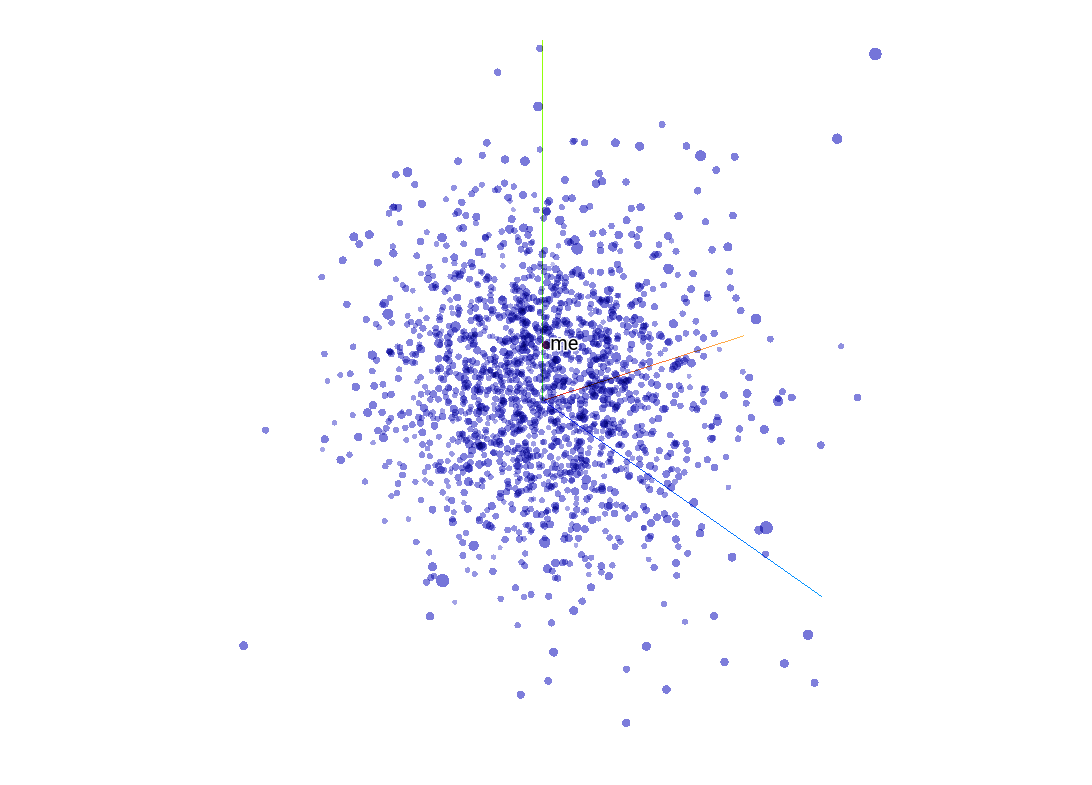
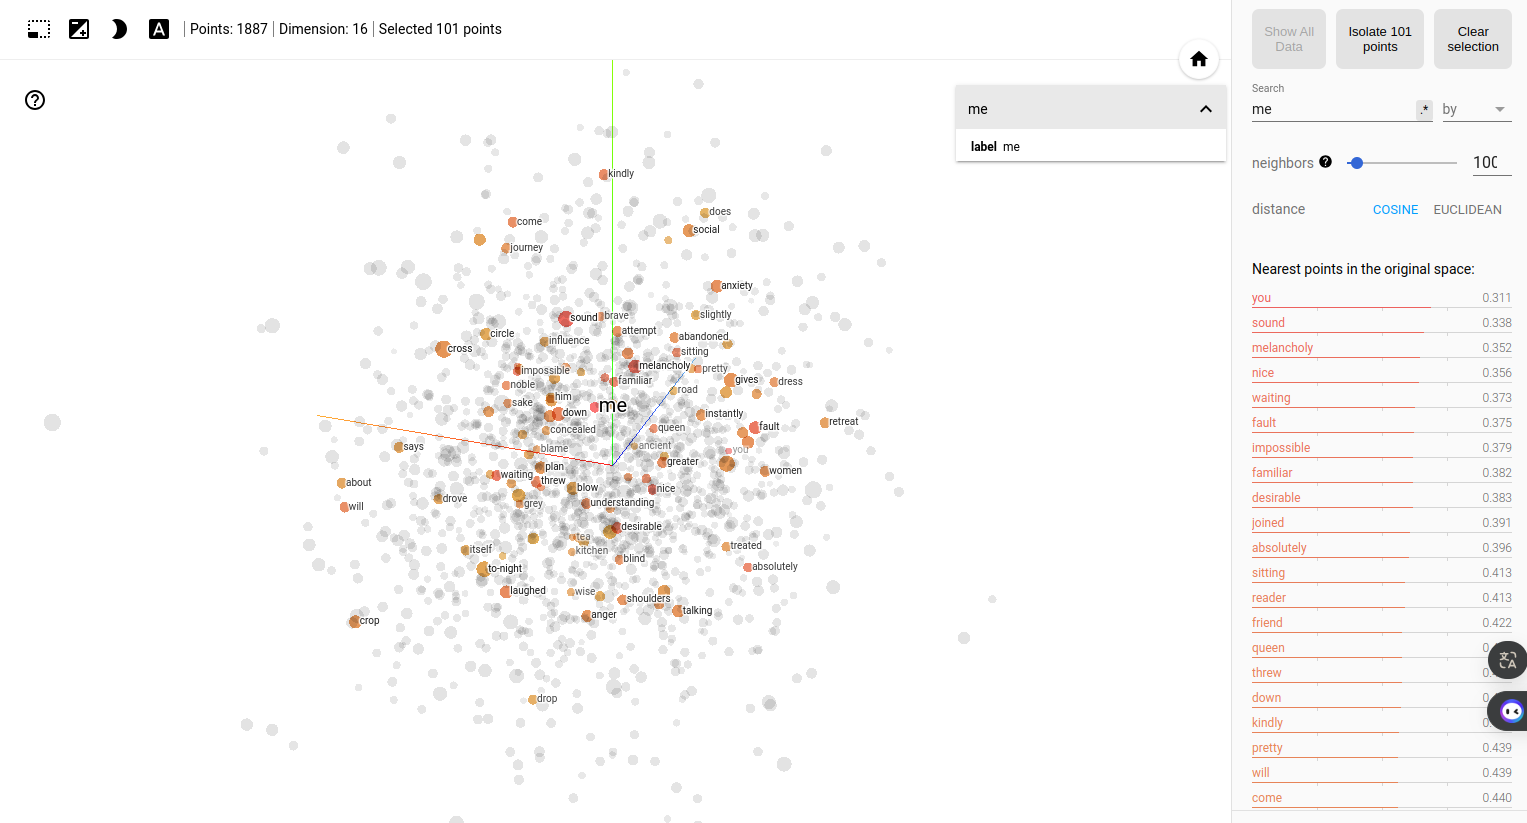
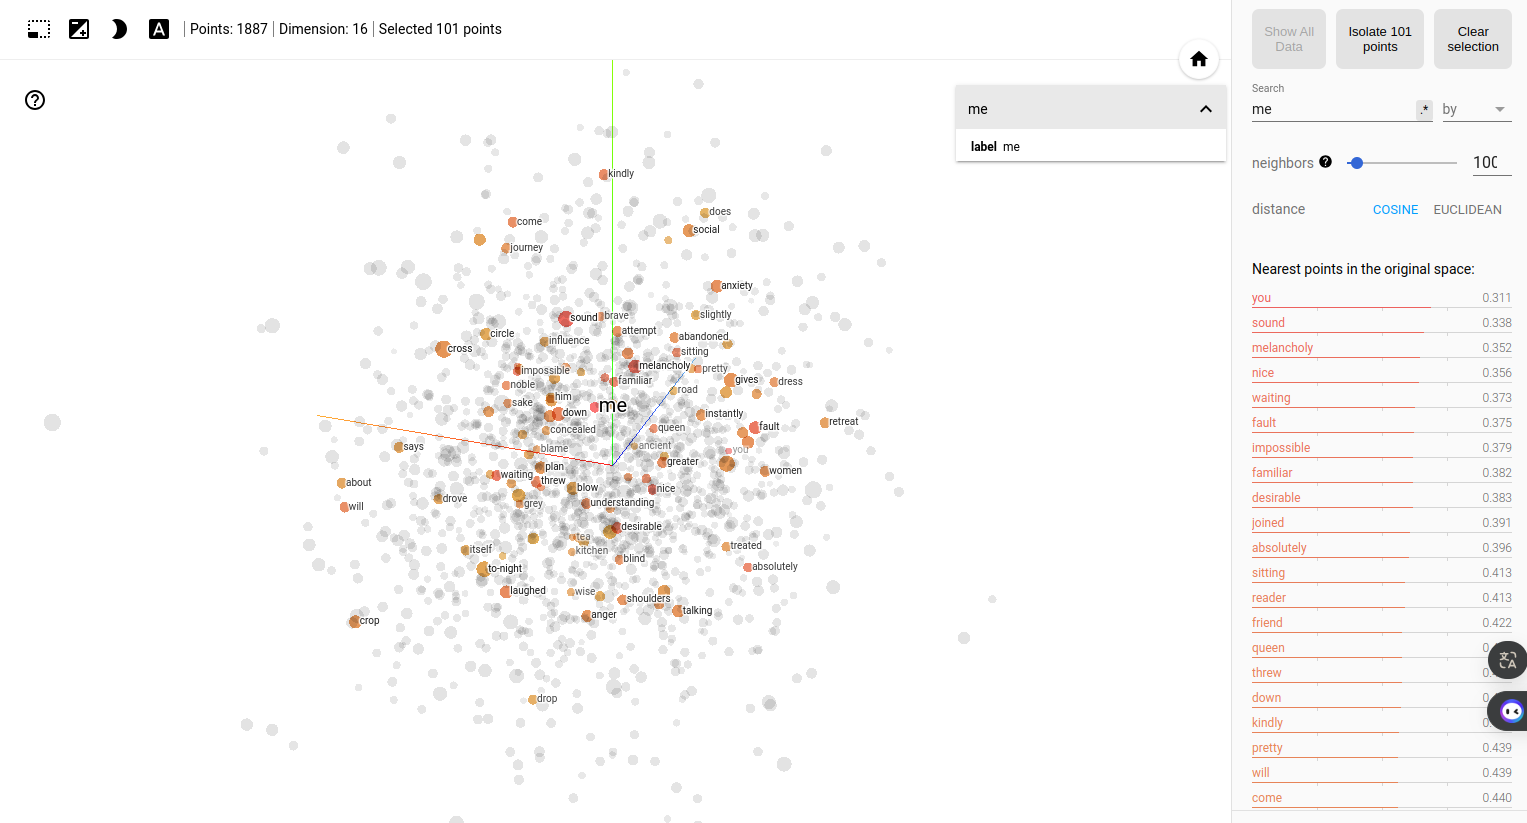

_______________________________
# 2.2 Conjugating be and have:

For this part we would first need to make the 12 first words in our vocab be the possible conjugations as the neuronal netowrk will give a value from 0-11. This will ensure that the output word is one the conjugations

In [ ]:
from torchtext.vocab import vocab as Vocab
from collections import Counter, OrderedDict

counter = Counter(words_train)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)

target_output = []

for element in sorted_by_freq_tuples:
    # Put the chosen ones at the beggining
    if element[0] in TARGET_OUTPUT:
        target_output.insert(0, element)
    else:
        target_output.append(element)

ordered_dict = OrderedDict(target_output)
specials = TARGET_OUTPUT + ['<unk>']
vocab_conjugate = Vocab(ordered_dict, specials=specials)
vocab_conjugate.set_default_index(vocab_conjugate['<unk>'])
vocab_conjugate_dict = vocab_conjugate.get_itos()


## 2.2.1 MLP and RNN prediction of be and have conjugation given the context around the target


Prepare the dataset with a set of words around the context

In [ ]:
target_to_idx = {target: i for i, target in enumerate(TARGET_OUTPUT)}

# Crear un diccionario para guardar las palabras y sus índices
target_to_idx = {}

# Buscar cada palabra y obtener su índice
for palabra in TARGET_OUTPUT:
    try:
        indice = vocab_conjugate_dict.index(palabra)
        target_to_idx[palabra] = indice
    except ValueError:
        print(f"La palabra '{palabra}' no se encontró en la lista.")
        target_to_idx[palabra] = None

# Mostrar los resultados
print("Índices de las palabras buscadas:")
for i, (palabra, indice) in enumerate(target_to_idx.items()):
    if indice is not None:
        print(f"{i}: '{palabra}' está en el índice {indice}.")
    else:
        print(f"{i}: '{palabra}' no está en la lista.")


def create_aroundTarget_dataset(text, vocab, before_context_size, after_context_size):
    contexts = []
    targets = []
    lenText = len(text)

    for i in range(before_context_size, lenText - after_context_size):

        word = text[i]

        if word in TARGET_OUTPUT:

            t = target_to_idx[word]
            

            around = (
                text[i - before_context_size : i]
                + text[i + 1 : i + after_context_size + 1]
            )

            c = torch.Tensor([vocab[w] for w in around]).type(torch.long)

            # The index of the target has to be from 0 to 11 not the vocab one
            targets.append(t)
            contexts.append(c)

    contexts = torch.stack(contexts)
    targets = torch.tensor(targets)
    return TensorDataset(contexts, targets)

before_context_size=6
after_context_size=6
batch_size = 256

# Creating Tensors for 12 words before and 6 after the target
before_context_size= 12; after_context_size=6
train_conjugate_data_12_6 = create_aroundTarget_dataset(words_train, vocab_conjugate, before_context_size, after_context_size)
val_conjugate_data_12_6 = create_aroundTarget_dataset(words_val, vocab_conjugate, before_context_size, after_context_size)
test_conjugate_data_12_6 = create_aroundTarget_dataset(words_test, vocab_conjugate, before_context_size, after_context_size)

train_conjugate_data_loader_12_6 = DataLoader(train_conjugate_data_12_6, batch_size=batch_size, shuffle=True)
val_conjugate_data_loader_12_6 = DataLoader(val_conjugate_data_12_6, batch_size=batch_size, shuffle=True)
test_conjugate_data_loader_12_6 = DataLoader(test_conjugate_data_12_6, batch_size=batch_size, shuffle=True)


""" filtered_train_conjugate_data_12_6 = create_aroundTarget_dataset(filtered_words_train, vocab_conjugate, before_context_size, after_context_size)
filtered_val_conjugate_data_12_6 = create_aroundTarget_dataset(filtered_words_val, vocab_conjugate, before_context_size, after_context_size)
filtered_test_conjugate_data_12_6 = create_aroundTarget_dataset(filtered_words_test, vocab_conjugate, before_context_size, after_context_size)

filtered_train_conjugate_data_loader = DataLoader(filtered_train_conjugate_data_12_6, batch_size=batch_size)
filtered_val_conjugate_data_loader = DataLoader(filtered_val_conjugate_data_12_6, batch_size=batch_size)
filtered_test_conjugate_data_loader = DataLoader(filtered_test_conjugate_data_12_6, batch_size=batch_size) """

# Creating Tensors for 5 words before and 5 after the target
before_context_size= 5; after_context_size=5
train_conjugate_data_5_5 = create_aroundTarget_dataset(words_train, vocab_conjugate, before_context_size, after_context_size, )
val_conjugate_data_5_5 = create_aroundTarget_dataset(words_val, vocab_conjugate, before_context_size, after_context_size)
test_conjugate_data_5_5 = create_aroundTarget_dataset(words_test, vocab_conjugate, before_context_size, after_context_size)

train_conjugate_data_loader_5_5 = DataLoader(train_conjugate_data_5_5, batch_size=batch_size, shuffle=True)
val_conjugate_data_loader_5_5 = DataLoader(val_conjugate_data_5_5, batch_size=batch_size, shuffle=True)
test_conjugate_data_loader_5_5 = DataLoader(test_conjugate_data_5_5, batch_size=batch_size, shuffle=True)



Check the train data

In [ ]:
print("TARGET: ")
print(target_to_idx)

# Acceder a la palabra correspondiente al índice 0
word_at_index_0 = vocab_conjugate_dict[0]
print(f"The word with index 0: {word_at_index_0}\n")

index = (200, 210)

print("************** Tensors-> 12 Words before, 6 after examples: **************")
for i in range(*index):
    input_tensor, target_tensor = train_conjugate_data_12_6[i]
    input_tensor = input_tensor.tolist()
    target_tensor = target_tensor.item()

    # Inicializar la frase
    phrase = ""

    # Añadir las primeras 5 palabras del input_tensor a la frase
    for value in input_tensor[:before_context_size]:
        phrase += vocab_conjugate_dict[value] + " "

    # Añadir la palabra del target_tensor a la frase
    phrase += " *"+ vocab_conjugate_dict[target_tensor] + "* "

    # Añadir los últimos 2 valores del input_tensor a la frase
    for value in input_tensor[-after_context_size:]:
        phrase += vocab_conjugate_dict[value] + " "

    # Imprimir la frase completa
    print(" Input: ", input_tensor," Target: ", target_tensor, "-> {", vocab_conjugate_dict[target_tensor], "}""\n   -> {", phrase.strip(),  "}")

print("\n************** Tensors-> 5 Words before, 5 after examples: **************")
for i in range(*index):
    input_tensor, target_tensor = train_conjugate_data_5_5[i]
    input_tensor = input_tensor.tolist()
    target_tensor = target_tensor.item()

    # Inicializar la frase
    phrase = " "

    # Añadir las primeras 5 palabras del input_tensor a la frase
    for value in input_tensor[:before_context_size]:
        phrase += vocab_conjugate_dict[value] + " "

    # Añadir la palabra del target_tensor a la frase
    phrase += "*"+ vocab_conjugate_dict[target_tensor] + "* "

    # Añadir los últimos 2 valores del input_tensor a la frase
    for value in input_tensor[-after_context_size:]:
        phrase += vocab_conjugate_dict[value] + " "

    # Imprimir la frase completa
    print(" Input: ", input_tensor," Target: ", target_tensor, "-> {", vocab_conjugate_dict[target_tensor], "}""\n   -> {", phrase.strip(),  "}")


### Create the models

#### RNN model

In [ ]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, cell) = self.rnn(x)
        last_hidden = output[:, -1, :]
        out = self.fc(last_hidden)
        return out

    def predict(self, x):
        self.eval()
        with torch.no_grad():
            output = self.forward(x)
            _, predicted_index = torch.max(output, 1)
        return predicted_index

# Ejemplo de uso:
# rnn_model.predict(input_tensor)

#### MLP model

In [ ]:
class MLPModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_weights, output_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.embeddings.load_state_dict({"weight": embedding_weights})
        self.embeddings.requires_grad = False

        self.classifier = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=output_dim),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        output = self.classifier(embeds)

        # Only ouput class label, not features
        output = output[:, 0, :]

        return output

## 2.2.2. Train models and evaluate performance


In [ ]:

def train(n_epochs, optimizer, model, loss_fn, train_loader, device=None):
    device = set_device(device)

    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for contexts, targets in train_loader:

            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 5 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

In [ ]:
models_5_5 = [] # Models trained with 5 words before and 5 after
models_5_5_titles = [] # Titles
models_12_6 = [] # Models trained with 12 words before 6 after
models_12_6_titles = [] # Titles
mlp_model_counter=0

learning_rates=[0.001, 0.005, 0.01, 0.05]
hidden_dim=[100, 200, 300, 500, 700, 900]
n_epochs = 1 # 485 is the maximum



Train the MLP model

In [ ]:
""" MLP_MODEL_PATH = "MLP_model.pt"

if os.path.isfile(PATH_GENERATED + MLP_MODEL_PATH):
    mlp_model = torch.load(PATH_GENERATED + MLP_MODEL_PATH)
else:
    embedding_dim = 16

    # Hyperparameters
    input_dim = 20  # Each word is embedded into embedding_dim dimensions
    hidden_dim = 100
    output_dim = len(TARGET_OUTPUT)  # 12 possible target words

    # Instantiate the model
    mlp_model = MLPModel(len(vocab_conjugate), embedding_dim, best_model_weights, len(TARGET_OUTPUT))

    loss_fn = nn.NLLLoss()
    n_epochs = 100
    lr = 0.001
    optimizer = optim.SGD(mlp_model.parameters(), lr=lr)

    train(n_epochs, optimizer, mlp_model, loss_fn, train_conjugate_data_loader)
    torch.save(mlp_model , PATH_GENERATED + MLP_MODEL_PATH)

models.append(mlp_model)
titles.append("MLP") """

#### Train the RNN models

trained with 16 words context before and 4 words context after

In [ ]:
def train_all_rnn_models(learning_rates, hidden_dimensions, train_loaders, vocab, output_dim, n_epochs):

    rnn_model_counter=0
    loss_fn = nn.CrossEntropyLoss()
    RNN_MODEL_PATH_DEFAULT = "models/"

    for train_loader, train_loader_title in train_loaders:  # For every change in the amount of words we pick before/after the target 
        print("Traning the Dataloader: ", train_loader_title)
        for model_dimension in hidden_dimensions:     # For every model we create
            model =  RNNModel(len(vocab), embedding_dim, model_dimension, output_dim)
            print("  Traning the model-dimension: ", model_dimension)
            for learning_rate in learning_rates:      # For every learning rate
                print("    Traning the lr: ", learning_rate)

                optimizer = optim.Adam(model.parameters(), lr=learning_rate)
                rnn_model_counter +=1
                modelTitle= "RNN_"+str(rnn_model_counter) +"_("+ train_loader_title +")_lr=" +str(learning_rate) 

                file_path = PATH_GENERATED + RNN_MODEL_PATH_DEFAULT + modelTitle + ".pt"
                
                if os.path.isfile(file_path): # If it has not been trained before
                    model = torch.load(file_path)
                else:
                    train(n_epochs, optimizer, model, loss_fn, train_loader)
                    torch.save(model, file_path)
                

                if train_loader_title == "Before=5,After=5":
                    if modelTitle not in titles: # Dont add again if it is already there
                        models_5_5.append(model)
                        models_5_5_titles.append(modelTitle)
                        
                elif train_loader_title == "Before=12,After=6":
                    if modelTitle not in titles: # Dont add again if it is already there
                        models_12_6.append(model)
                        models_12_6_titles.append(modelTitle)
                


In [ ]:

learning_rates=[0.001, 0.005, 0.01, 0.05]
hidden_dim=[100, 200, 300, 500, 700, 900]
train_loaders=[(train_conjugate_data_loader_5_5,"Before=5,After=5") , (train_conjugate_data_loader_12_6, "Before=12,After=6")]
n_epochs = 1 # 485 is the maximum

train_all_rnn_models(learning_rates, hidden_dim, train_loaders, vocab_conjugate, len(TARGET_OUTPUT), n_epochs)



#### RNN Model 2

trained with 5 words context before and 5 words context after. Lr = 0.001

#### RNN Model 3

Trained with 5 words before the context and 5 after, chaging learning rate to lr=0.005

Demostration of the predictions

In [ ]:

def predict_single_example(model, input, vocab):
    first_input, first_label = input

    first_input = first_input.unsqueeze(0)  # Agrega una dimensión de batch
    first_label = torch.tensor([first_label])  # Asegúrate de que está en formato tensor    
    # Asumiendo que rnn_model es tu modelo y ya está cargado y movido al dispositivo adecuado
    model.eval()  # Coloca el modelo en modo de evaluación

    # Realiza la predicción
    with torch.no_grad():
        output = model(first_input)
        _, predicted_index = torch.max(output, 1)
        predicted_index = predicted_index.item()  # Convierte el tensor a un entero Python

    input_tensor, target_tensor = input
    input_tensor = input_tensor.tolist()
    target_tensor = target_tensor.item()

    # Inicializar la frase
    phrase = ""

    # Añadir las primeras 5 palabras del input_tensor a la frase
    for value in input_tensor[:before_context_size]:
        phrase += vocab[value] + " "

    # Añadir la palabra del target_tensor a la frase
    phrase += "*"+ vocab[target_tensor] + "* "

    # Añadir los últimos 2 valores del input_tensor a la frase
    for value in input_tensor[-after_context_size:]:
        phrase += vocab[value] + " "

    # Imprimir la frase completa
    predicted_word = vocab[predicted_index]
    real_word = vocab[first_label.item()]
    print(f"[Predicted Word: {predicted_word},\tReal Word: {real_word}]", " \t-> Phrase: ", phrase.strip())


def predictSamples(models, modelTitles, vocab, train_loaders, since=100, to=105):
    
    for i, model in enumerate(models):
        model_title= modelTitles[i]
        print("\n***************** Prediccting model: ", model_title, "*****************")
        for train_loader, train_loader_title in train_loaders:
            print("Train data predictions for "+train_loader_title+": ")
            for i in range (since,to):
                predict_single_example(model, train_loader[i], vocab)


# train_loaders=[(train_conjugate_data_loader_5_5,"Before=5,After=5") , (train_conjugate_data_loader_12_6, "Before=12,After=6")]
predictSamples(models_5_5, models_5_5_titles, vocab_conjugate_dict, train_conjugate_data_loader_5_5, since=110, to=113)
predictSamples(models_12_6, models_12_6_titles, vocab_conjugate_dict, train_conjugate_data_loader_12_6, since=110, to=113)


Here we can see better some examples of how the neural network is working for each model in each type of data

Selection of the best model

We now have to change a little bit how we meausre the performace as we have different approaches. For example we have an approach that will read 12 words before the target and 6 after and another approach that will instead read 5 before and 5 after. Each have different train/val/test DataLoaders, so we can not mix them.

In [ ]:
def model_selection_multipleLoaders(data):
    for conjugation in data:
        model, title, train_loader, val_loader, test_loader = data
    
        best_model = None
        best_acc = 0
        for model in models:
            acc = accuracy(model, val_loader)
            train_acc = accuracy(model, train_loader)
            print(f"{title} | Train accuracy {train_acc:.2%} |  Validation accuracy {acc:.2%}")
            if acc > best_acc:
                best_model = model
                best_acc = acc
        return best_model

In [ ]:

all_models_data=[
                    [models_5_5, models_5_5_titles, train_conjugate_data_5_5, val_conjugate_data_5_5, test_conjugate_data_5_5],
                    [models_12_6, models_12_6_titles, train_conjugate_data_12_6, val_conjugate_data_12_6, test_conjugate_data_12_6],
          ]

model_selection_multipleLoaders(all_models_data)



_______________________________
# 2.3 Text generation:
## 2.3.1. Next Word


## 2.3.2. Train models and evaluate performance


## 2.3.3. Beam Search


## 2.3.3. Sentence creation